In [ ]:
%load_ext jbmagics

# Problem adaption

## Create a sinusoidal groundwater level

In [2]:
from flopy.mbase import run_model

import matplotlib.pyplot as plt
import numpy as np

from pymf6tools.custom_print import CustomPrint

from helpers import make_model_input, get_flux, plot

The water level with oscillate between 320 and 325 meters:

In [3]:
h_mean, h_min, h_max = 320.0, 315.0, 325.0

In [4]:
amplitude = (h_min - h_max) / 2.0

Using 401 discrete time steps, we get this sinus curve of the groundwater level:

In [5]:
ntimesteps = 401
ihalf = int(ntimesteps / 2) + 1
x = np.linspace(-np.pi, np.pi, ntimesteps)
chd_head = amplitude * np.sin(x) + h_mean

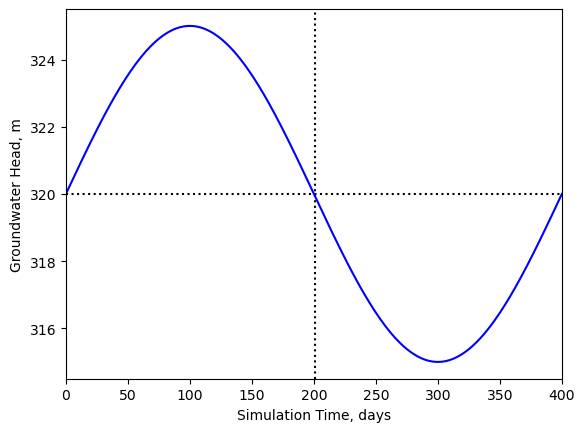

In [6]:
plt.axhline(h_mean, color="black", ls=":")
ax = plt.gca()
ax.axvline(ihalf, color="black", ls=":")
ax.plot(chd_head, color="blue")
ax.set_xlabel("Simulation Time, days")
ax.set_ylabel("Groundwater Head, m")
ax.set_xlim(0, 400);

## Creating a model

Using `flopy`, we create a simple MODFLOW model.
It is has 2 layers, 1 row, and 1 column. 
There are two boundary conditions, 
(a) constant head will in the lower layer (layer 2) and 
(b) the river boundary cell in the upper layer model (layer 1):

In [7]:
%%include helpers.py
end_at = "import matplotlib"
import_module = True

```python
"""Helpers to create a MF6 model."""

from pathlib import Path

import flopy.mf6 as fp
import matplotlib.pyplot as plt
```


In [8]:
%%include helpers.py
start_at = "def make_model_input"
end_at = "return sim"
import_module = True

```python
def make_model_input(name, chd_head, h_mean):
    """Create model input."""
    ws = Path(name)
    sim = fp.MFSimulation(sim_name=name, sim_ws=ws, memory_print_option='all')
    pd = [(1, 1, 1.0)] * chd_head.shape[0]
    tdis = fp.ModflowTdis(sim, nper=len(pd), perioddata=pd)
    ims = fp.ModflowIms(
        sim, complexity='simple', outer_dvclose=1e-6, inner_dvclose=1e-6
    )
    gwf = fp.ModflowGwf(
        sim,
        modelname=name,
        print_input=True,
        save_flows=True,
    )
    dis = fp.ModflowGwfdis(
        gwf,
        nlay=2,
        nrow=1,
        ncol=1,
        delr=1.0,
        delc=1.0,
        top=360,
        botm=[220, 200],
    )
    npf = fp.ModflowGwfnpf(
        gwf,
        k=50.0,
        k33=10.0,
    )
    ic = fp.ModflowGwfic(gwf, strt=chd_head[0])
    condref = 1.0
    spd = [((0, 0, 0), h_mean, condref, 319.0)]
    riv = fp.ModflowGwfriv(
        gwf, stress_period_data=spd, pname='RIVER', print_flows=True
    )
    spd = {idx: [((1, 0, 0), h)] for idx, h in enumerate(chd_head)}
    chd = fp.ModflowGwfchd(gwf, stress_period_data=spd, print_flows=True)
    oc = fp.ModflowGwfoc(
        gwf,
        head_filerecord=f'{name}.hds',
        budget_filerecord=f'{name}.cbc',
        printrecord=[('budget', 'all')],
        saverecord=[('head', 'all'), ('budget', 'all')],
    )
    sim.write_simulation()
    return sim
```


Create the input files:

In [9]:
name = 'rivercond'
sim = make_model_input(name, chd_head, h_mean)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model rivercond...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package river...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 1 based on size of stress_period_data
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


and run the model:

## Running the model

In [10]:
sim.run_simulation(custom_print=CustomPrint(show_each_stress_period=False));

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software User Rights Notice for complete use, copyright, 
and distribution information

## Looking at the results

We retrieve the flux from the river boundary cell:

In [11]:
%%include helpers.py
start_at = "def get_flux"
end_at = "return"
import_module = True

```python
def get_flux(sim, name):
    """Get flux data model output."""
    gwf = sim.get_model(name)
    bud = gwf.output.budget()
    riv = bud.get_data(text='RIV')
    flux = [float(entry['q'][0]) for entry in riv]
    return flux
```


In [12]:
%%include helpers.py
start_at = "def get_flux"
end_at = "return"
import_module = True

```python
def get_flux(sim, name):
    """Get flux data model output."""
    gwf = sim.get_model(name)
    bud = gwf.output.budget()
    riv = bud.get_data(text='RIV')
    flux = [float(entry['q'][0]) for entry in riv]
    return flux
```


In [13]:
flux = get_flux(sim, name)

and plot its values over time:

In [14]:
%%include helpers.py
start_at = "def plot"
end_at = "return"
import_module = True

```python
def plot(flux, vmin=-0.6, vmax=0.6, cell_name='river'):
    """Plot the river flux."""
    fig, ax = plt.subplots(
        nrows=1,
        ncols=1,
        layout='constrained',
        figsize=(4.5, 5),
    )
    ax.set_title(f'Flux in {cell_name} cell')
    ax.set_xlim(0, 400.0)
    ax.set_ylim(vmin, vmax)
    ax.set_xlabel('Simulation time, days')
    ax.set_ylabel('Flow tate, m$^3$/d')
    ax.axhline(0, lw=0.5, ls='-.', color='black')
    ax.plot(
        flux,
        color='black',
        lw=1.0,
        label='River flux',
    )
    ax.legend()
    return ax
```


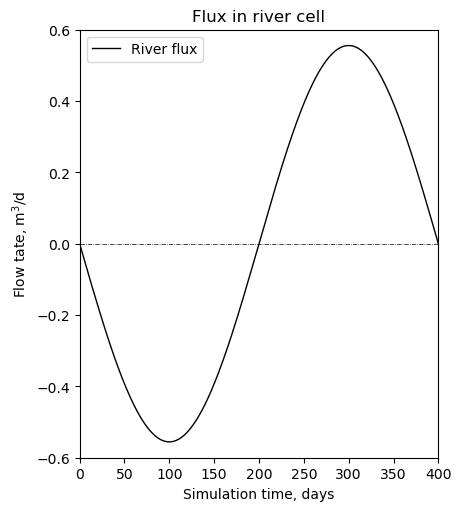

In [16]:
plot(flux);

The flux shows the same pattern as the groundwater level.
The river conductance is constant.